In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from google.cloud import storage
from project_config import GCP_PROJECT_NAME

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

/home/gautamsai_y/.conda/envs/rv_timm0412/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configuration

In [4]:
from os.path import expanduser

from experiment_configs.unet_fs_config import unet_orig_config, unet_resblocks_config, resnet18_unet_config
from experiment_configs.satmae_ft_config import satmae_ft_doubleupsampling_config, satmae_ft_lineardecoder_config
from experiment_configs.resnetmoco_ft_config import resnet50_moco_ft_config
config = unet_orig_config
#config.output_dir = expanduser("~/sandmining-watch/out/1009_resnet50_moco")

### Create Rastervision datasets

In [5]:
from torch.utils.data import ConcatDataset

from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, warn_if_nan_in_raw_raster
from utils.data_management import observation_factory

from project_config import is_training, is_validation


all_observations = observation_factory(gcp_client)
training_scenes = []
validation_scenes = []

for observation in all_observations:
    scene = observation_to_scene(config, observation)    
    training_scenes.append(scene)



training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes
]


2023-11-01 19:27:03:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/s2/Godavari_EastGodavari_81-84_16-66_2022-06-01_s2.tif.
2023-11-01 19:27:03:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/s1/Godavari_EastGodavari_81-84_16-66_2022-06-01_s1.tif.
2023-11-01 19:27:04:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/annotations/Godavari_EastGodavari_81-84_16-66_2022-06-01_annotations.geojson.


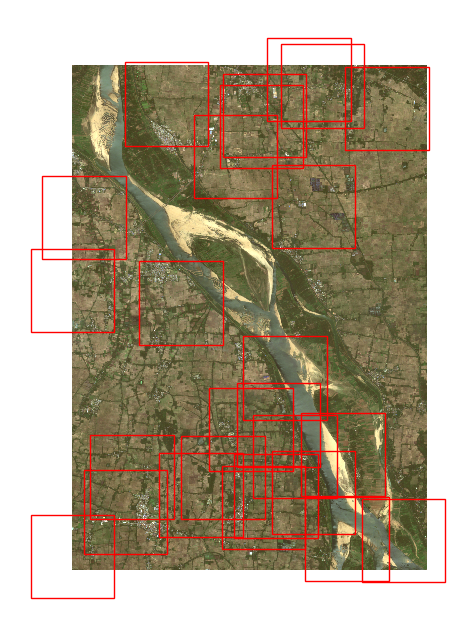

In [6]:
from utils.visualizing import Visualizer
visualizer = Visualizer(config.s2_channels)

train_ds = training_datasets[0]
windows = [train_ds.sample_window() for _ in range(train_ds.max_windows)]
visualizer.show_windows(
    train_ds.scene.raster_source.get_image_array(),
    windows
)

# val_ds = validation_datasets[0]
# visualizer.show_windows(
#     val_ds.scene.raster_source.get_image_array(),
#     val_ds.windows
# )


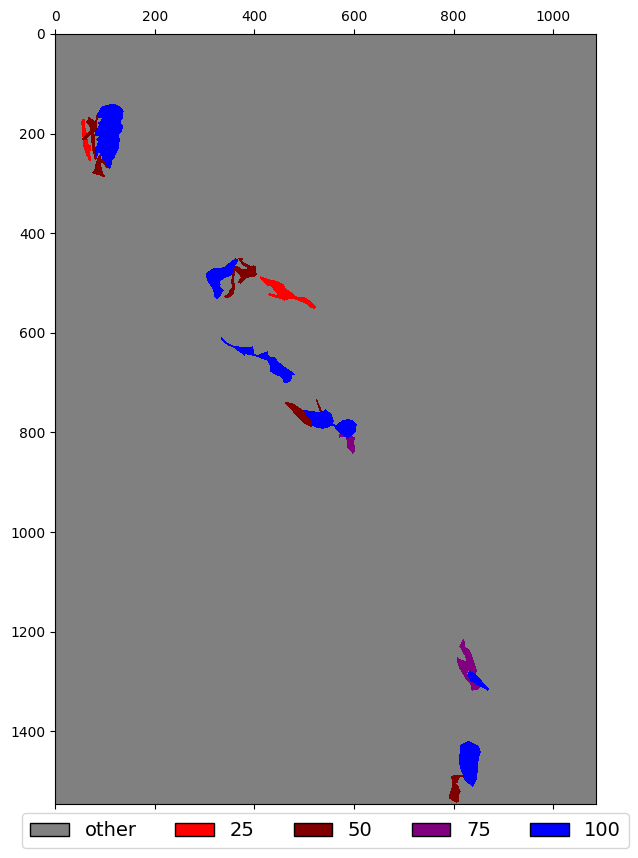

In [7]:
from utils.visualizing import show_labels
# show_labels(train_ds.scene.label_source.get_labels())
# train_ds.scene.label_source.get_label_arr()

show_labels(train_ds.scene.label_source.get_label_arr())

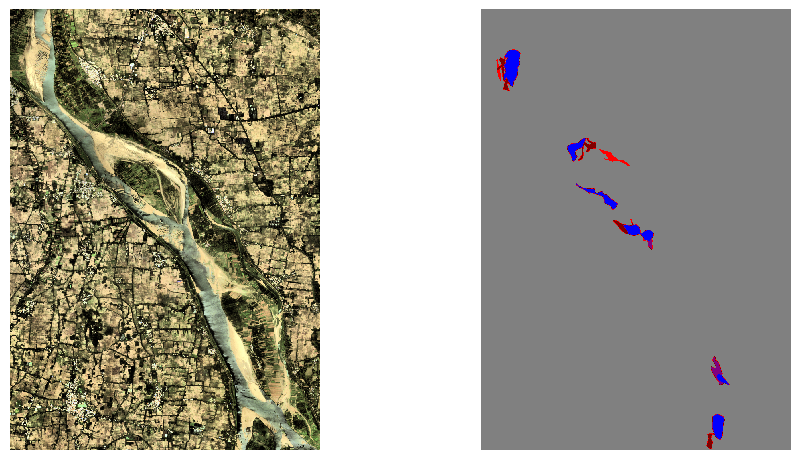

In [8]:
from utils.visualizing import show_rgb_with_labels

visualizer.show_rgb_with_labels(train_ds.scene.raster_source.get_image_array(), train_ds.scene.label_source.get_label_arr())

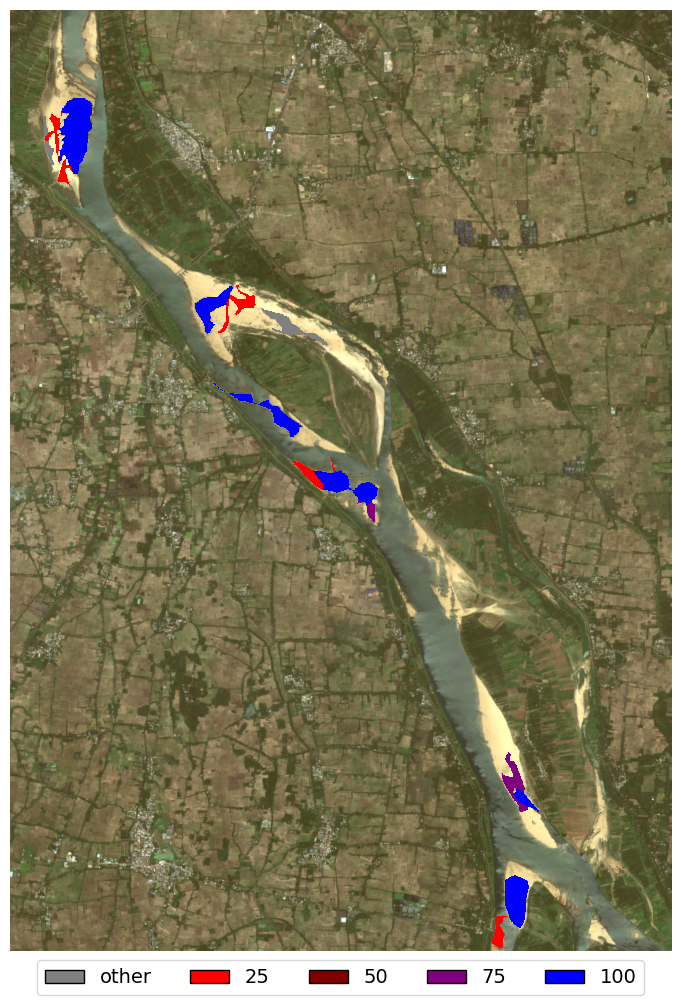

In [9]:
visualizer.show_rgb_overlay_labels(train_ds.scene.raster_source.get_image_array(), train_ds.scene.label_source.get_label_arr())

In [10]:
import numpy as np
np.max(train_ds.scene.label_source.get_label_arr())

1.0

# Train

In [11]:
# import torch
# torch.cuda.empty_cache()

In [12]:
from models.model_factory import model_factory
from ml.optimizer_factory import optimizer_factory
from ml.custom_learner import learner_factory
import torch

_, _, n_channels = training_datasets[0].scene.raster_source.shape
# model = model_factory(
#     config,
#     n_channels=n_channels,
# )
model = torch.nn.Conv2d(n_channels, 1, 3, padding=1)

optimizer = optimizer_factory(config, model)

learner = learner_factory(
    config=config,
    model=model,
    optimizer=optimizer,
    training_ds=training_datasets[0],  # for development and debugging, use training_datasets[0] or similar to speed up
    validation_ds=training_datasets[0],  # for development and debugging, use training_datasets[1] or similar to speed up
)
learner.log_data_stats()

2023-11-01 19:27:23:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from /home/gautamsai_y/sandmining-watch/out/unet_small/last-model.pth
2023-11-01 19:27:23:rastervision.pytorch_learner.learner: INFO - train_ds: 26 items
2023-11-01 19:27:23:rastervision.pytorch_learner.learner: INFO - valid_ds: 26 items


#### Check GPU Activity

You can continuously monitor your GPU activity by using the command in the terminal


`watch -d -n 0.5 nvidia-smi`

In [13]:
# Run this cell if you want to log the run to W&B. You might need to authenticate to W&B.
# learner.initialize_wandb_run()

In [15]:
learner.train(epochs=1)
learner.save_model_bundle()

2023-11-01 19:31:35:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 45
2023-11-01 19:31:35:rastervision.pytorch_learner.learner: INFO - epoch: 45
Validating: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]
2023-11-01 19:31:44:rastervision.pytorch_learner.learner: INFO - metrics:
{'100_f1': 0.0,
 '100_precision': 0.0,
 '100_recall': 0.0,
 '25_f1': 0.0,
 '25_precision': 0.0,
 '25_recall': 0.0,
 '50_f1': 0.0,
 '50_precision': 0.0,
 '50_recall': 0.0,
 '75_f1': 0.0,
 '75_precision': 0.0,
 '75_recall': 0.0,
 'avg_f1': 0.9791563153266907,
 'avg_precision': 0.9723373055458069,
 'avg_recall': 0.9860716462135315,
 'epoch': 45,
 'other_f1': 0.9929870367050171,
 'other_precision': 0.9860716462135315,
 'other_recall': 1.0,
 'train_loss': 0.0030013775596251856,
 'train_time': datetime.timedelta(seconds=4, microseconds=421108),
 'val_loss': 0.005196207668632269,
 'valid_time': datetime.timedelta(seconds=4, microseconds=570625)}
2023-11-01 19:31:44:rastervision.pytorch_learner.

## Evaluate 

Run inference on validation sites and log results to W&B

In [ ]:
learner.evaluate_and_log_to_wandb(validation_datasets)